In [2]:
import os
import sys
parent_dir = os.path.abspath(os.path.join(os.path.join(os.getcwd(), ".."), ".."))
sys.path.append(parent_dir)
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from collections import Counter
from data_generation.models.tech_substitution import TechnologySubstitution
from data_generation.models.tech_substitution import TechSubNumericalSolver
from data_generation.models.general_ode_solver import FitzHughNagumoModel
from data_generation.models.general_ode_solver import GeneralODENumericalSolver
from data_generation.simulations.grid import Grid, fractional_transformation, logistic_transformation
from data_generation.simulations.simulator import Simulator, run_and_store_simulations
from data_generation.simulations.stopping_criteria import calculate_entropy, create_stopping_by_entropy_threshold_criteria, entropy_of_uniform_distribution_over_percentage
from data_generation.visualization.create_plots import plot_2D_vector_field_over_grid

In [3]:
def plot_entropy_and_vectorfield(cell_indices, grid, num_solver, control,resolution, fig, axes, title):
    cell_data = cell_indices.reshape(-1, cell_indices.shape[-1])
    num_steps = cell_indices.shape[0] -1
    entropy_value, unique, probabilities = calculate_entropy(cell_data, base= 2)

    # Reshape probabilities to match the grid resolution
    probabilities_reshaped = probabilities.reshape(resolution)

    
    # Adjust the aspect ratio to match the grid resolution
    extent = [0, 1, 0, 1]
    im = axes.imshow(probabilities_reshaped.T, cmap='viridis', origin='lower', extent=extent, aspect='auto', alpha=0.6)
    fig.colorbar(im, ax=axes, label='Probability')
    
    plot_2D_vector_field_over_grid(grid, num_solver, control, display_vectorfield=False, display_grid = True, resolution=21, title= 'Prior Probabilities', broken_streamlines=False, ax= axes, streamplot_colour='black', vectorfield_colour='red')

    axes.set_title(title + f' - Entropy: {entropy_value:.2f}  - Num_Steps: {num_steps}')
    
    return 


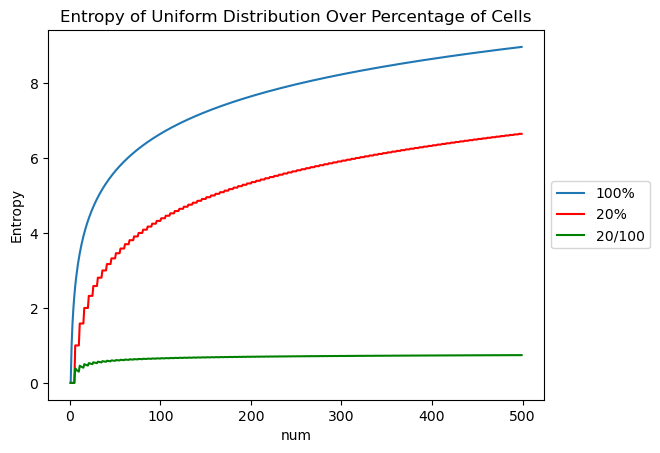

In [6]:
r = range(1,500)
values = [entropy_of_uniform_distribution_over_percentage(num, 1) for num in r]
values04 = [entropy_of_uniform_distribution_over_percentage(num, 0.2) for num in r]
v = [val04 / val if val != 0 else 0 for val, val04 in zip(values, values04)]
plt.plot(r, values)
plt.plot(r, values04, color='red')
plt.plot(r, v, color='green')
plt.xlabel('num')
plt.ylabel('Entropy')
plt.title('Entropy of Uniform Distribution Over Percentage of Cells')
plt.legend(['100%', '20%', '20/100'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Tech Substitution Test

In [7]:
bounds = [(0, np.inf), (0, np.inf)]
transformations = [fractional_transformation(3), fractional_transformation(3)]
model = TechnologySubstitution()
num_solver = TechSubNumericalSolver(model)
control = np.array(1)
resolution = [30, 30]
num_samples_per_cell = 5
num_steps = 80
max_steps = 500
delta_t = 1

In [8]:
n = np.prod(resolution)
percentage = 0.4


In [9]:
grid = Grid(bounds, resolution, transformations)
simulator = Simulator(grid, model, num_solver)
threshold = entropy_of_uniform_distribution_over_percentage(np.prod(resolution), percentage)
stopping_criteria = create_stopping_by_entropy_threshold_criteria(threshold)
threshold

np.float64(8.491853096329674)

control = np.array(1)
data1, cell_indices1, at, tr = simulator.simulate_with_stopping_criteria(control, 
                                          delta_t, 
                                          stopping_criteria,
                                          num_samples_per_cell, 
                                          max_steps=max_steps,
                                          num_steps=num_steps)

control = np.array(0.5)
data05, cell_indices05, at, tr = simulator.simulate_with_stopping_criteria(control, 
                                          delta_t, 
                                          stopping_criteria,
                                          num_samples_per_cell, 
                                          max_steps=max_steps,
                                          num_steps=num_steps)

plot_entropy_and_vectorfield(cell_indices05, grid, num_solver, np.array(0.5), resolution)

Caution: Maximum number of steps reached (500)
Simulation complete:
- 4500 samples × 560 timesteps = 2520000 total rows
- State dimensions: 2
- Control dimensions: 1
Stopped at entropy: 6.380229022593018 <= 6.491853096329675 (threshold)
Simulation complete:
- 4500 samples × 560 timesteps = 2520000 total rows
- State dimensions: 2
- Control dimensions: 1


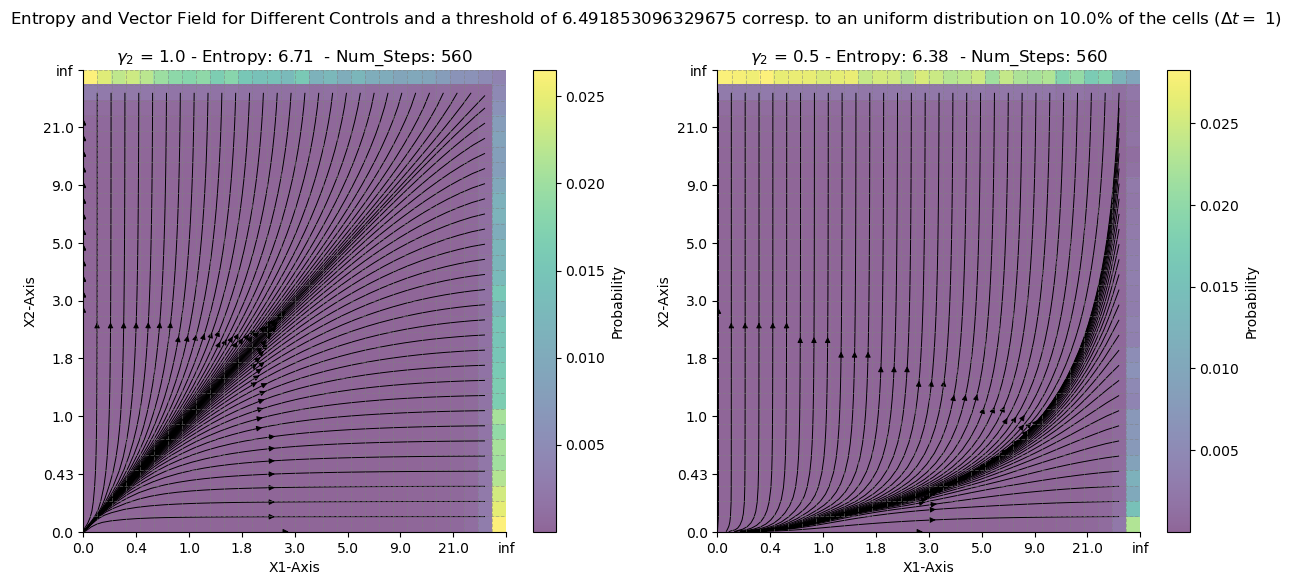

In [10]:
percentagelist = [0.1]
for percentage in percentagelist:
    threshold = entropy_of_uniform_distribution_over_percentage(np.prod(resolution), percentage)
    stopping_criteria = create_stopping_by_entropy_threshold_criteria(threshold)
    control = np.array([[1], [0.5]])

    # Create a plot
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    for i in range(2):
        data, cell_indices = simulator.simulate_with_stopping_criteria(control[i], 
                                                delta_t, 
                                                stopping_criteria,
                                                num_samples_per_cell, 
                                                max_steps=max_steps,
                                                num_steps=num_steps)
        
        plot_entropy_and_vectorfield(cell_indices, grid, num_solver, control[i], resolution, fig, axes[i], r"$\gamma_{2}$ = " + str(control[i][0]))
    
    fig.suptitle(rf'Entropy and Vector Field for Different Controls and a threshold of {threshold} corresp. to an uniform distribution on {percentage*100}% of the cells ($\Delta t =$ {delta_t})')
    plt.savefig(f'entropy_vectorfield_{percentage}.png')

In [31]:
cell_indices.shape[0]


101

## FitzHugh-Nagumo Model Test

In [25]:
fbounds = [(-np.inf,np.inf),(-np.inf,np.inf)]
ftransformations = [logistic_transformation({'k': 1, 'x_0': 0}), logistic_transformation({'k': 1, 'x_0': 0})]

fmodel = FitzHughNagumoModel(control_params=['b','I'])
fnum_solver = GeneralODENumericalSolver(fmodel)
resolution = [30, 30]
num_samples_per_cell = 5
num_steps = 1
max_steps = 200
fdelta_t = 0.5

In [26]:
n = np.prod(resolution)
percentage = 0.9

In [27]:
fgrid = Grid(fbounds, resolution, ftransformations)
fsimulator = Simulator(fgrid, fmodel, fnum_solver)
threshold = entropy_of_uniform_distribution_over_percentage(np.prod(resolution), percentage)
stopping_criteria = create_stopping_by_entropy_threshold_criteria(threshold)
threshold

np.float64(9.661778097771986)

In [28]:
fcontrol = np.array([2, 0])
fdata, fcell_indices = fsimulator.simulate_with_stopping_criteria(fcontrol, 
                                          fdelta_t, 
                                          stopping_criteria,
                                          num_samples_per_cell, 
                                          max_steps=max_steps,
                                          num_steps=num_steps)

Stopped at entropy: 9.625752013167697 <= 9.661778097771986 (threshold)
Simulation complete:
- 4500 samples × 1 timesteps = 4500 total rows
- State dimensions: 2
- Control dimensions: 2


X = np.atleast_2d(at[0][0])
fshaped_control = np.array([[fcontrol]])
traj = fnum_solver.step(X, fshaped_control, 1, 3, steady_control=True)

In [29]:
fdata

run_id trajectory_id   t0   t1        x0        x1  c0  c1  \
0     20250228_105823         0-0_0  0.0  0.5 -5.969637 -5.252176   2   0   
1     20250228_105823         0-0_1  0.0  0.5 -3.394331 -3.958012   2   0   
2     20250228_105823         0-0_2  0.0  0.5 -7.034819 -4.660782   2   0   
3     20250228_105823         0-0_3  0.0  0.5 -3.791854 -3.598921   2   0   
4     20250228_105823         0-0_4  0.0  0.5 -3.655789 -3.403375   2   0   
...               ...           ...  ...  ...       ...       ...  ..  ..   
4495  20250228_105823       29-29_0  0.0  0.5  4.174431  3.546586   2   0   
4496  20250228_105823       29-29_1  0.0  0.5  3.651907  3.651541   2   0   
4497  20250228_105823       29-29_2  0.0  0.5  5.076822  3.799532   2   0   
4498  20250228_105823       29-29_3  0.0  0.5  8.102614  3.879918   2   0   
4499  20250228_105823       29-29_4  0.0  0.5  3.408683  3.489999   2   0   

            y0        y1  
0    -0.814314 -4.907769  
1    -0.921927 -3.697610  
2    -1.067591 -4.371316  
3    -1.120196 -3.373434  
4    -1.160699 -3.192520  
...        ...       ...  
4495  1.178346  3.383141  
4496  1.068238  3.473711  
4497  1.188317  3.622707  
4498  1.346181  3.715093  
4499  1.075269  3.322483  

[4500 rows x 10 columns]

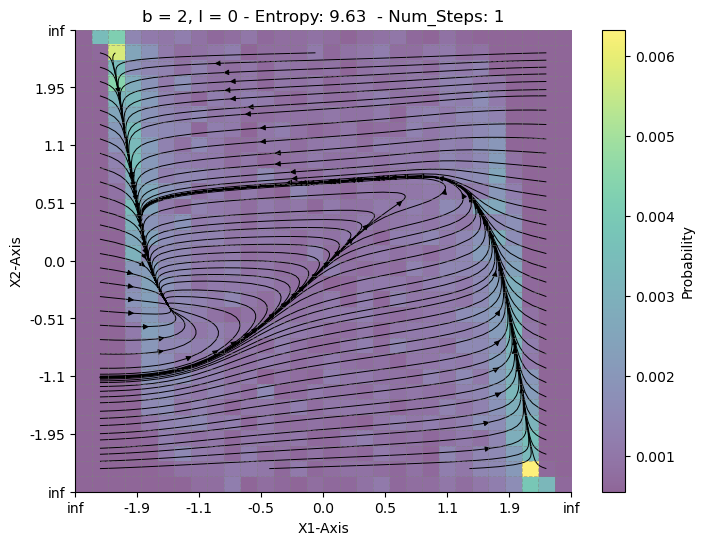

In [30]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

plot_entropy_and_vectorfield(fcell_indices, fgrid, fnum_solver, np.array([2, 0]), resolution, fig, axes, title= f"b = 2, I = 0")

Stopped at entropy: 9.625977028039745 <= 9.661778097771986 (threshold)
Simulation complete:
- 4500 samples × 1 timesteps = 4500 total rows
- State dimensions: 2
- Control dimensions: 2
Stopped at entropy: 9.625407398218302 <= 9.661778097771986 (threshold)
Simulation complete:
- 4500 samples × 1 timesteps = 4500 total rows
- State dimensions: 2
- Control dimensions: 2
Stopped at entropy: 9.625573087682564 <= 9.661778097771986 (threshold)
Simulation complete:
- 4500 samples × 1 timesteps = 4500 total rows
- State dimensions: 2
- Control dimensions: 2
Stopped at entropy: 9.05134739922645 <= 9.29920801838728 (threshold)
Simulation complete:
- 4500 samples × 3 timesteps = 13500 total rows
- State dimensions: 2
- Control dimensions: 2
Stopped at entropy: 9.046929418804046 <= 9.29920801838728 (threshold)
Simulation complete:
- 4500 samples × 3 timesteps = 13500 total rows
- State dimensions: 2
- Control dimensions: 2
Stopped at entropy: 9.040346316362974 <= 9.29920801838728 (threshold)
Simula

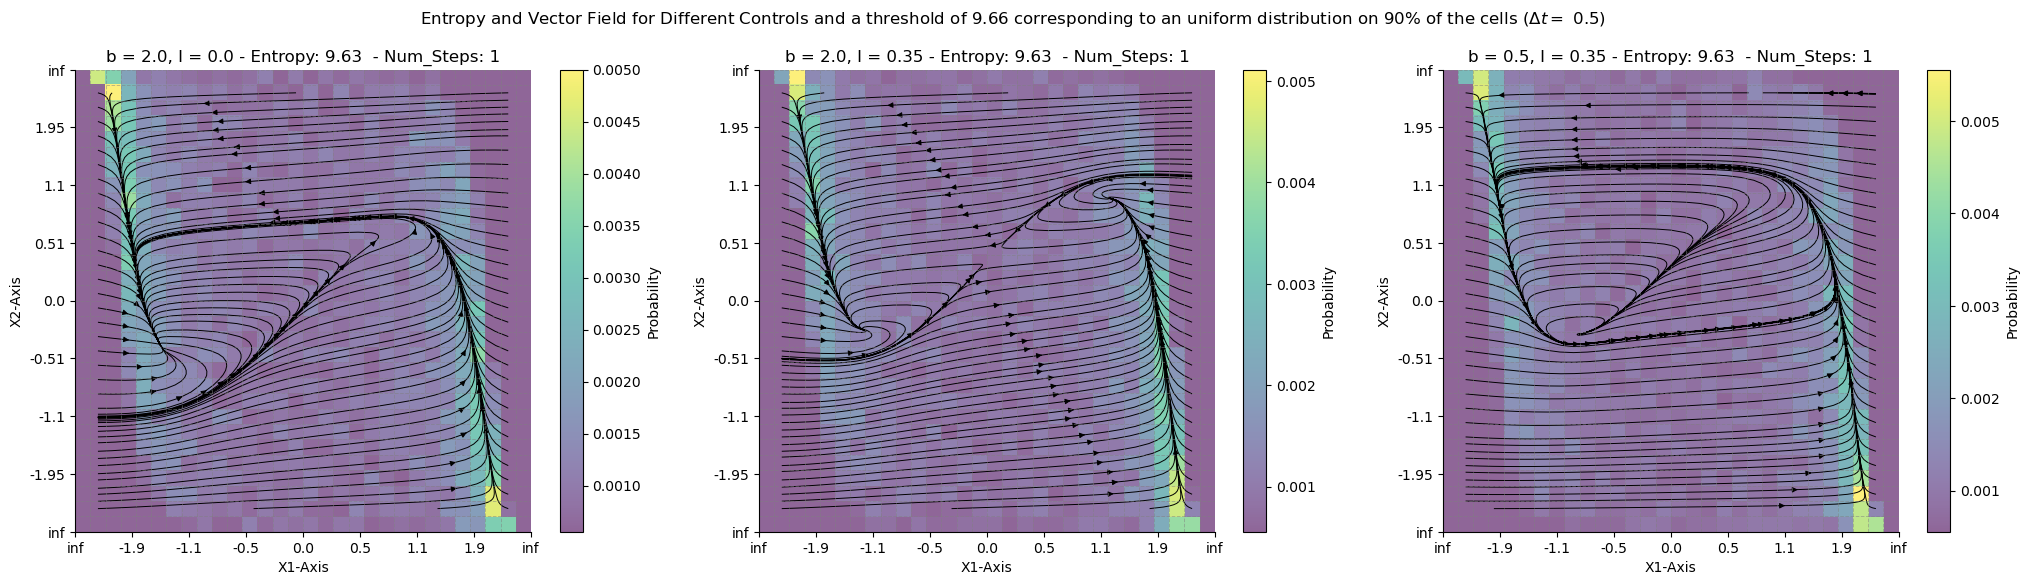

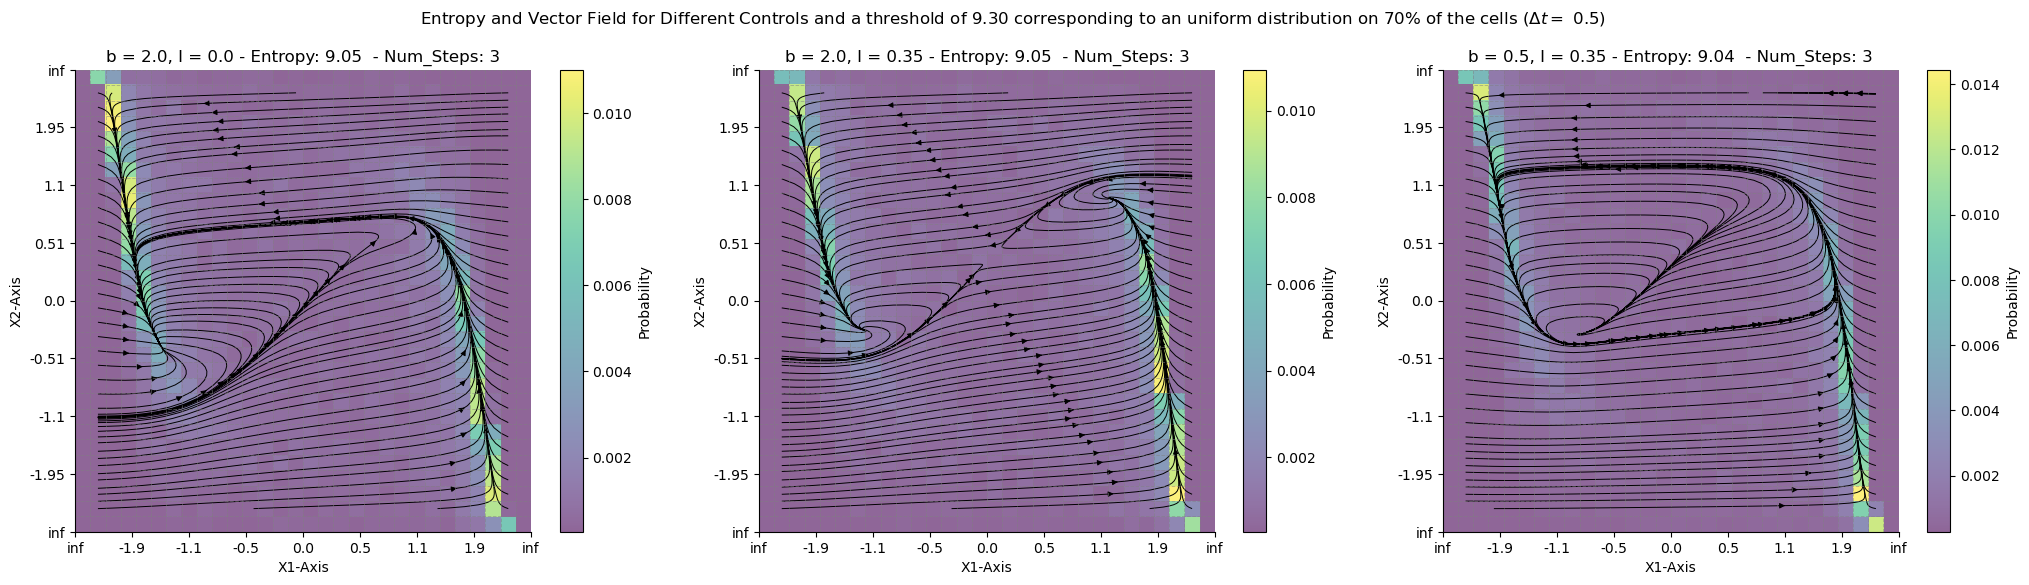

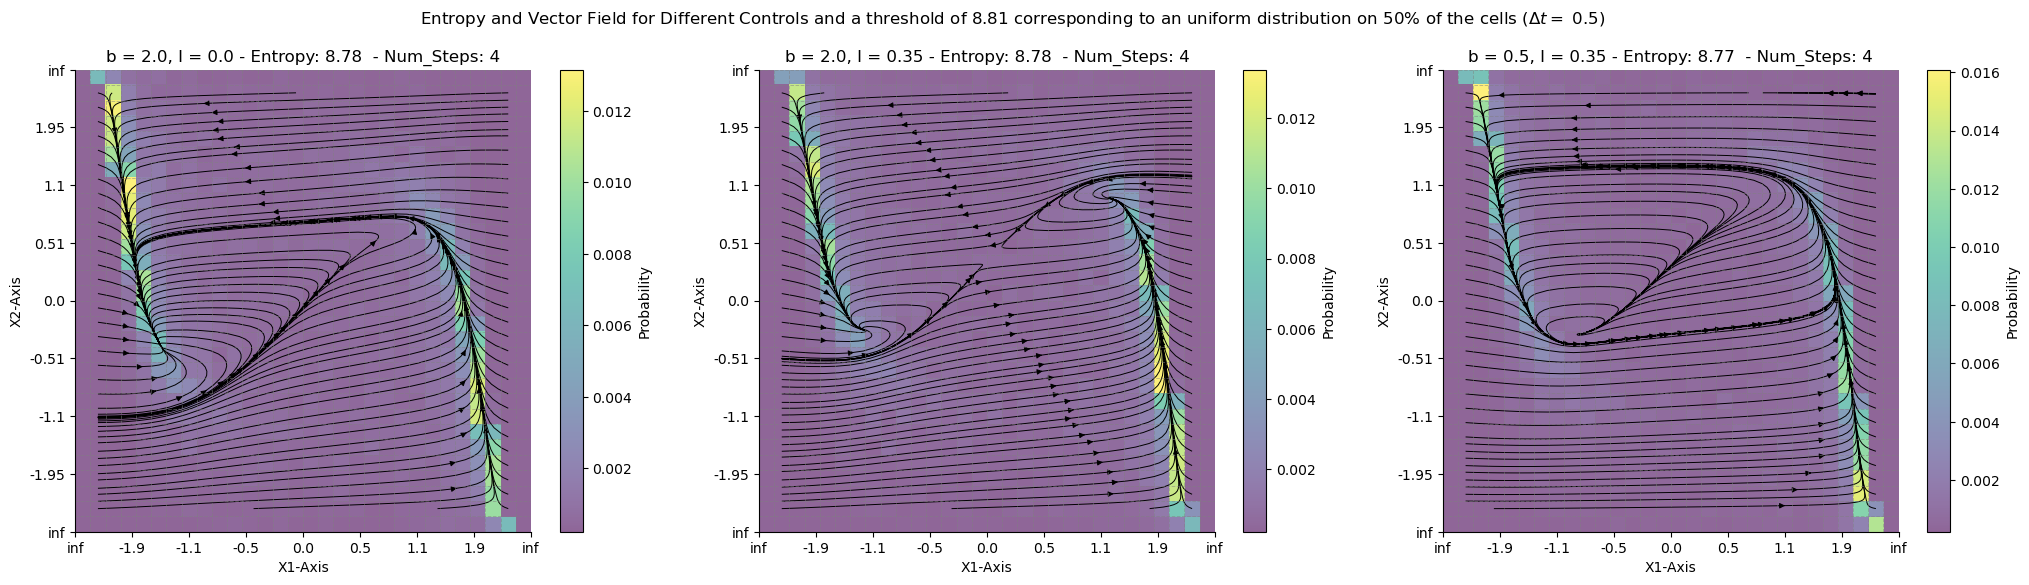

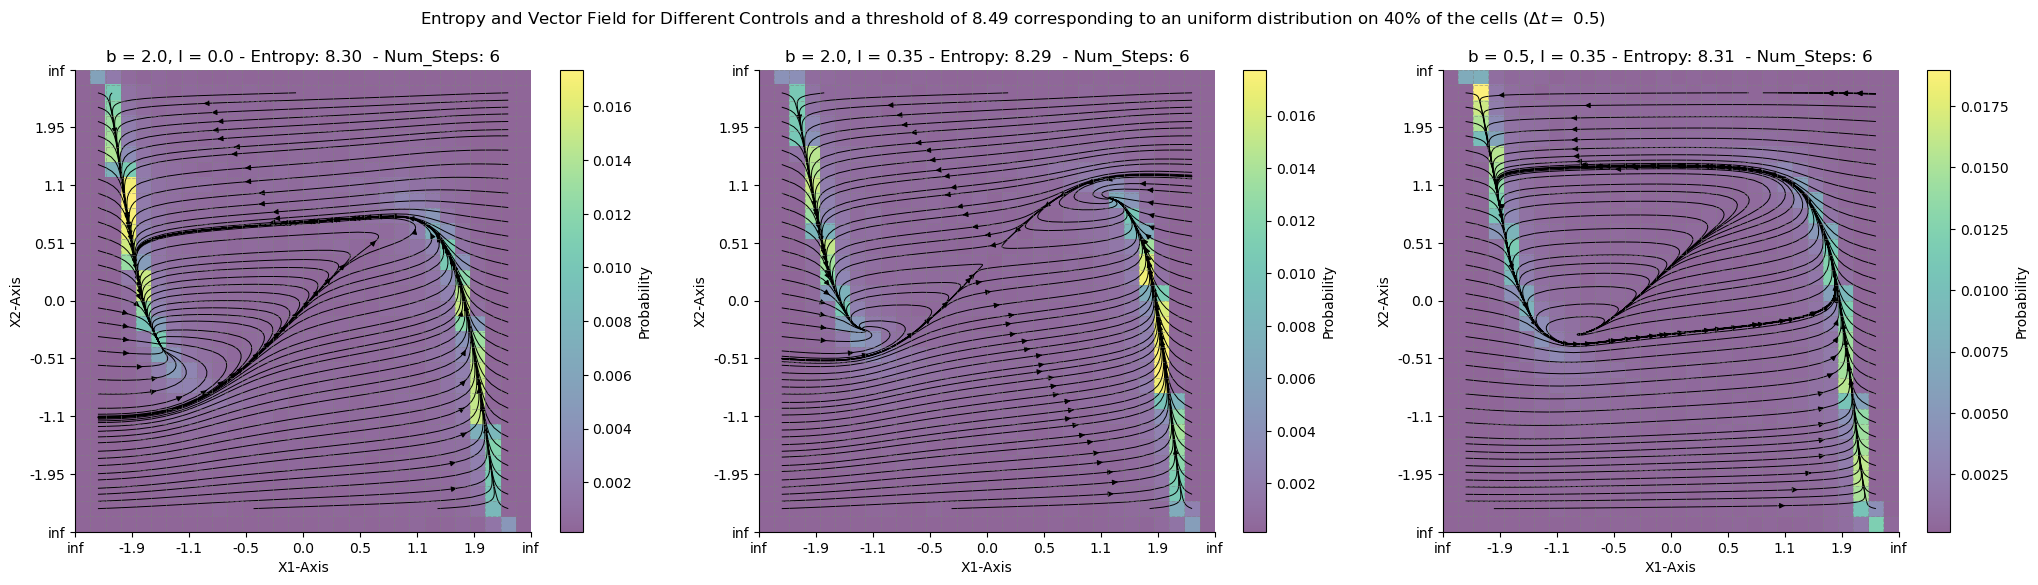

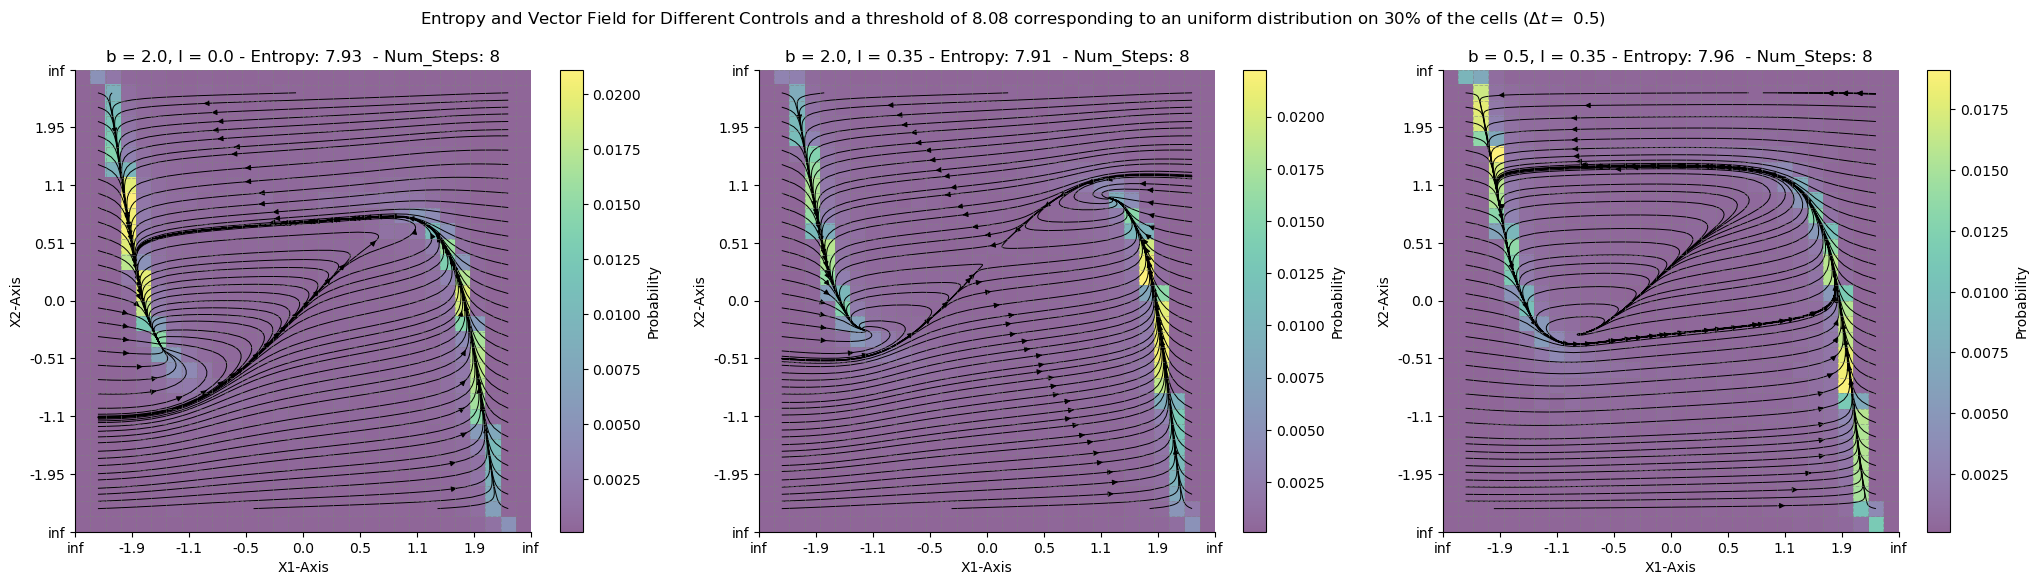

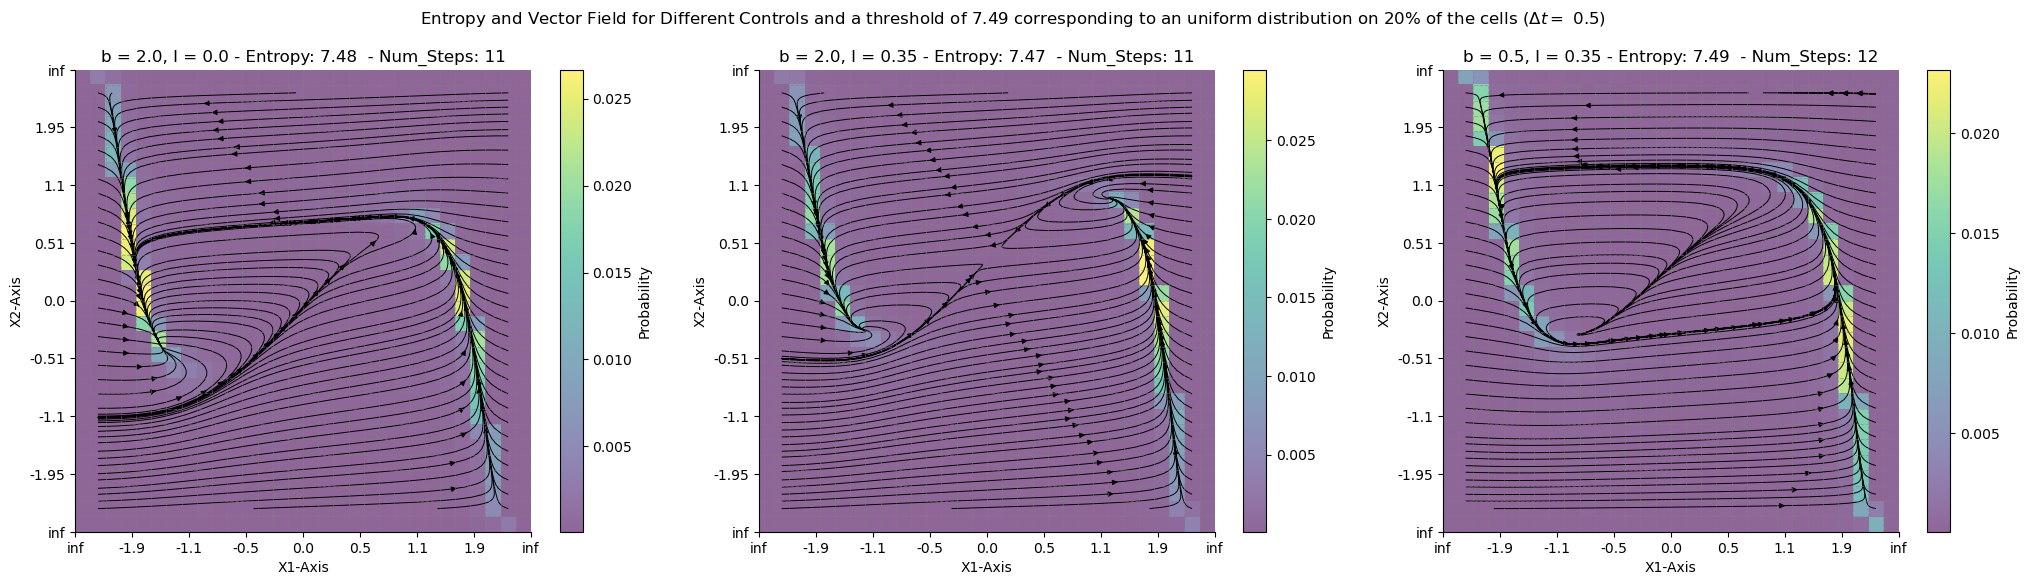

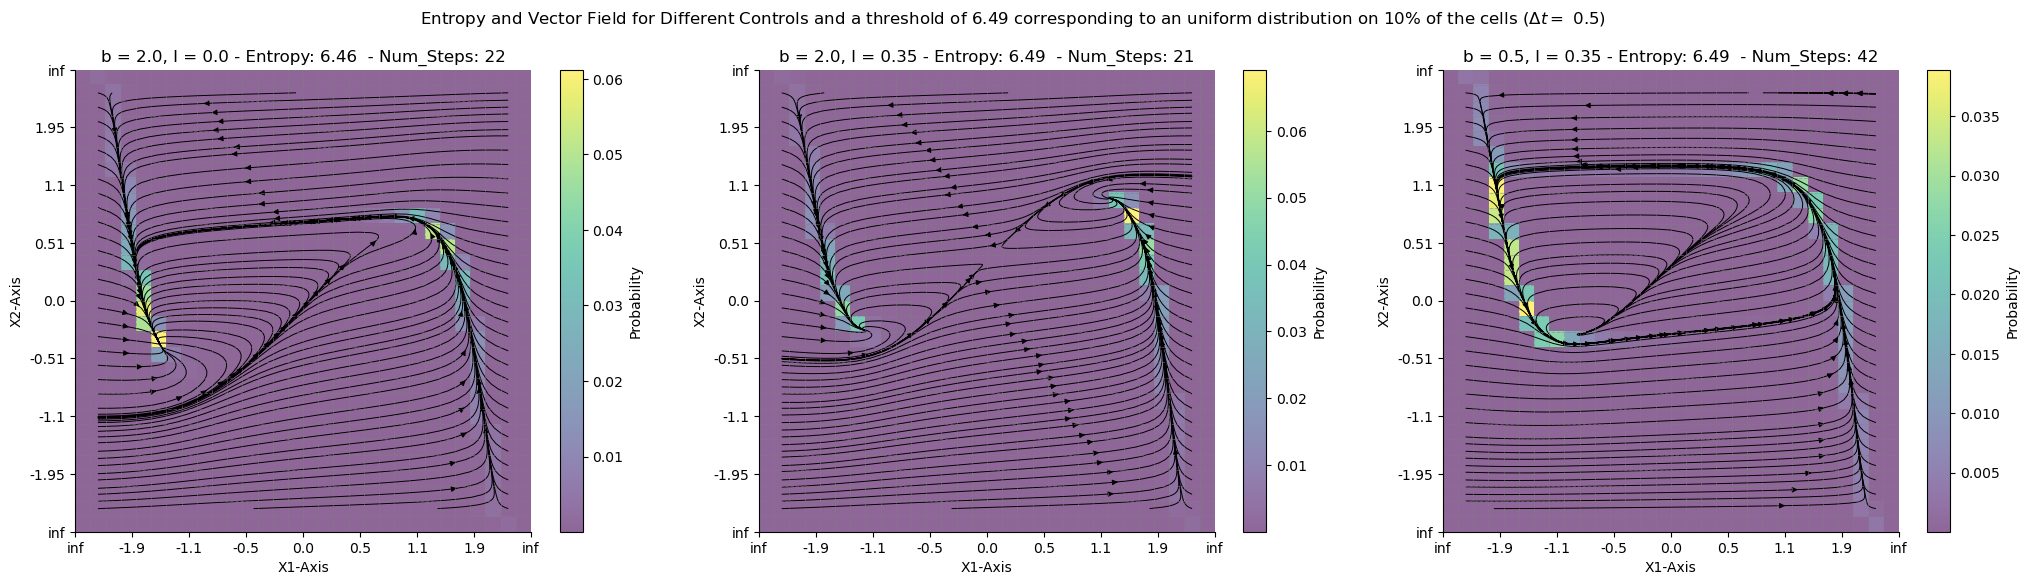

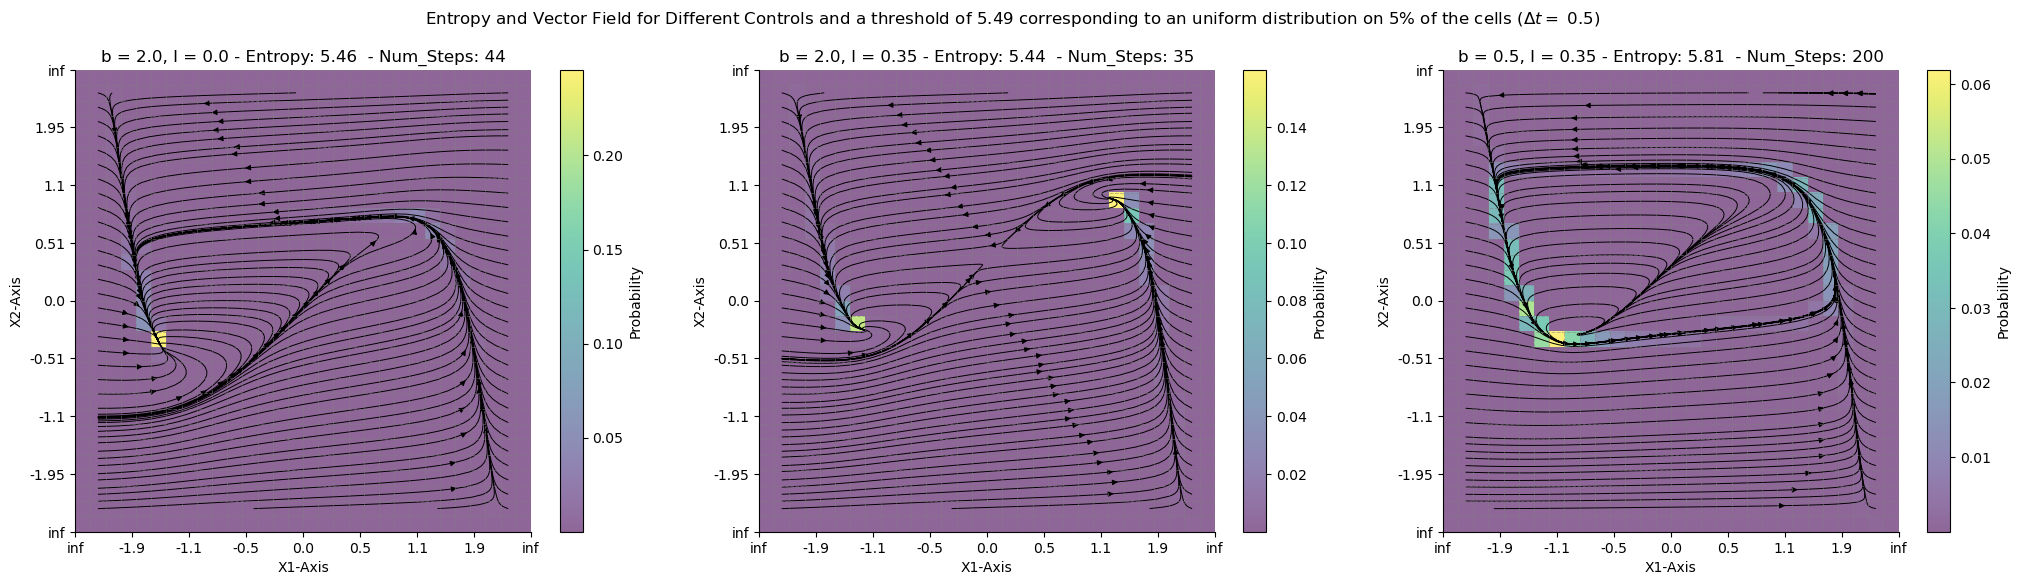

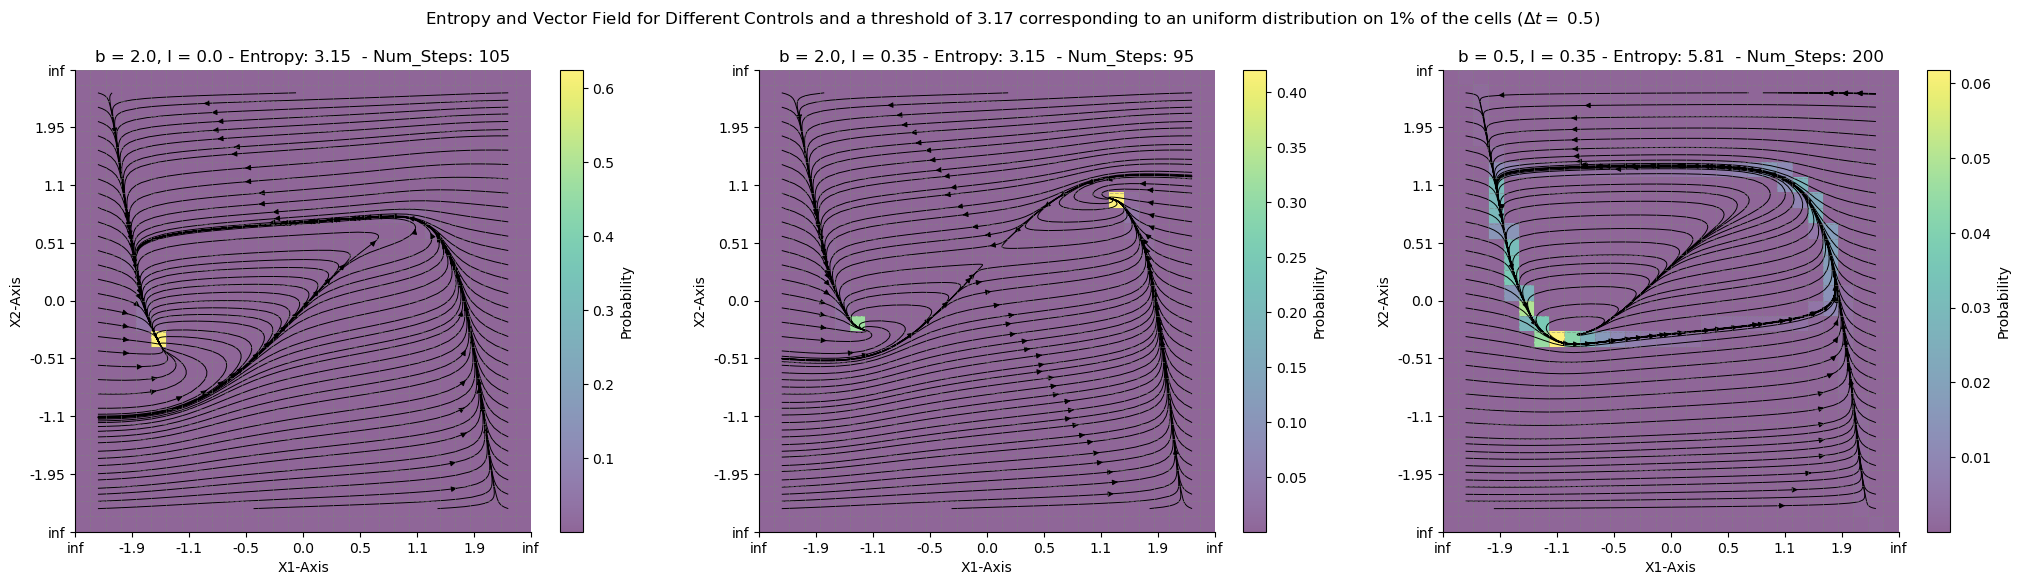

In [31]:
percentagelist = [0.9, 0.7, 0.5,0.4,0.3,0.2,0.1, 0.05, 0.01]
for percentage in percentagelist:
    threshold = entropy_of_uniform_distribution_over_percentage(np.prod(resolution), percentage)
    stopping_criteria = create_stopping_by_entropy_threshold_criteria(threshold)
    fcontrol = np.array([[2, 0], [2, 0.35], [0.5, 0.35]]) #check which control makes sense

    # Create a plot
    fig, axes = plt.subplots(1, 3, figsize=(25, 6))

    for i in range(len(fcontrol)):
        data, cell_indices = fsimulator.simulate_with_stopping_criteria(fcontrol[i], 
                                                fdelta_t, 
                                                stopping_criteria,
                                                num_samples_per_cell, 
                                                max_steps=max_steps,
                                                num_steps=num_steps)
        
        plot_entropy_and_vectorfield(cell_indices, fgrid, fnum_solver, fcontrol[i], resolution, fig, axes[i], title= f"b = {fcontrol[i][0]}, I = {fcontrol[i][1]}")
    
    fig.suptitle(rf'Entropy and Vector Field for Different Controls and a threshold of {threshold:.2f} corresponding to an uniform distribution on {percentage*100:.0f}% of the cells ($\Delta t =$ {fdelta_t})')
    plt.savefig(f'fhn_entropy_vectorfield_{(percentage*100):.0f}.png')

In [37]:
(1/3)*np.log(6) + 0.25*np.log(4) -(5/12)*np.log(5/12)

np.float64(1.308605387253449)

In [38]:
1.31 - 0.5*(1.1 +0.7)

0.41000000000000003

In [40]:
A = np.array([[1,2],[3,4],[5,6]])
A

array([[1, 2],
       [3, 4],
       [5, 6]])

In [45]:
B = A.transpose().flatten()
B

array([1, 3, 5, 2, 4, 6])

In [46]:
B.reshape(A.shape[1], A.shape[0]).transpose()

array([[1, 2],
       [3, 4],
       [5, 6]])